# Time series prediction with the fastai library

Based on [fast.ai Lesson 3](https://course.fast.ai/lessons/lesson3.html) on deep learning for structured data.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch, cv2
print(torch.cuda.is_available())

True


In [3]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [4]:
import os
data_dir = "../../data"
raw_data_dir = os.path.join(data_dir, "raw")
assert os.path.exists(raw_data_dir)
derived_data_dir = os.path.join(data_dir, "derived")
assert os.path.exists(derived_data_dir)
PATH=derived_data_dir

In [5]:
assert os.path.exists(PATH)

## Create datasets

In [6]:
items = pd.read_csv(os.path.join(raw_data_dir, "items.csv"))
sales_train = pd.read_csv(os.path.join(raw_data_dir, "sales_train.csv"))
test = pd.read_csv(os.path.join(raw_data_dir, "test.csv"))

In [7]:
weather = pd.read_csv(os.path.join(raw_data_dir, "tas_1991_2015.csv"))

In [8]:
# merge in category info to the data
sales_train = sales_train.merge(items, on="item_id", how="left").drop(columns="item_name")
test = test.merge(items, on="item_id", how="left").drop(columns="item_name")

In [9]:
# manually set the date and date_block_num for the test data, which is all from November 2015
test["date"] = "11.01.2015"
test["date_block_num"] = 34
test["year"] = 2015
test["month"] = 11

In [10]:
from IPython.display import HTML, display

In [12]:
# Compatibility issue with version 0.22.0 of pandas....
#DataFrameSummary(sales_train).summary()

## Create Train Dataset

In [11]:
dates = pd.to_datetime(sales_train.date, format="%d.%m.%Y")
sales_train["year"] = [d.year for d in dates]
sales_train["month"] = [d.month for d in dates]

In [12]:
# merge in weather info to the data
weather.columns = [col.lower().strip() for col in weather.columns.values]
weather.drop(columns=["country", "iso3", "iso2"], inplace=True)

In [13]:
print("sales_train\n", sales_train.dtypes)
print()
print("test\n", test.dtypes)

sales_train
 date                 object
date_block_num        int64
shop_id               int64
item_id               int64
item_price          float64
item_cnt_day        float64
item_category_id      int64
year                  int64
month                 int64
dtype: object

test
 ID                   int64
shop_id              int64
item_id              int64
item_category_id     int64
date                object
date_block_num       int64
year                 int64
month                int64
dtype: object


In [14]:
sales_train = sales_train.merge(weather, on=["year", "month"], how="left")
test = test.merge(weather, on=["year", "month"], how="left")

In [184]:
# create a new train dataset at the month level
month_cnt_list = []
month_price_dict = {}
processed = 0
errors = 0
for key, group in sales_train.groupby(by=["date_block_num", "year", "month", "shop_id", "item_id"]):
    processed += 1
    if processed % 100000 == 0:
        print(processed, "%.2f%%" % (processed / 1609124 * 100))
    if len(group) == 0:
        errors += 1
        continue
    
    date_block_num, year, month, shop_id, item_id = key
    item_cnt_month = np.sum(group.item_cnt_day)
    
    month_price_dict_key = "%d|%d|%d" % (shop_id, item_id, date_block_num)
    month_price = np.mean(group.item_price)
    month_price_dict[month_price_dict_key] = month_price
    
    month_cnt_list.append({"date_block_num": date_block_num, 
                           "year": year, 
                           "month": month, 
                           "shop_id": shop_id, 
                           "item_id": item_id, 
                           "item_cnt_month": item_cnt_month})
print(errors, processed)

100000 6.21%
200000 12.43%
300000 18.64%
400000 24.86%
500000 31.07%
600000 37.29%
700000 43.50%
800000 49.72%
900000 55.93%
1000000 62.15%
1100000 68.36%
1200000 74.57%
1300000 80.79%
1400000 87.00%
1500000 93.22%
1600000 99.43%
0 1609124


In [185]:
df = pd.DataFrame(month_cnt_list)
len(df)

1609124

In [ ]:
# set the prev month price for every month
# TODO

In [186]:
df.sample(n=5)

,date_block_num,item_cnt_month,item_id,month,shop_id,year
975408,18,1.0,20231,7,2,2014
735008,12,2.0,2017,1,55,2014
1313647,25,1.0,16287,2,24,2015
467892,8,1.0,5274,9,3,2013
1236354,23,1.0,20776,12,43,2014


In [187]:
test.sample(n=5)

,ID,shop_id,item_id,item_category_id,date,date_block_num,year,month,tas
128564,128564,47,13741,19,11.01.2015,34,2015,11,-16.051
124386,124386,52,17662,69,11.01.2015,34,2015,11,-16.051
114716,114716,49,4318,58,11.01.2015,34,2015,11,-16.051
162687,162687,56,1493,31,11.01.2015,34,2015,11,-16.051
93548,93548,14,12701,40,11.01.2015,34,2015,11,-16.051


In [188]:
# Set the train dataframe
train = df
train = train.merge(items, on="item_id", how="left").drop(columns="item_name")
train = train.merge(weather, on=["year", "month"], how="left")

In [189]:
train.to_feather(os.path.join(derived_data_dir, "train.df"))

In [15]:
train = pd.read_feather(os.path.join(derived_data_dir, "train.df"))

#### Month-level visualizations

In [17]:
shop_item_counts = {}
for shop_id in set(train.shop_id):
    items_in_shop = len(set(train[train.shop_id == shop_id].item_id))
    shop_item_counts[shop_id] = items_in_shop

In [18]:
# shops with the largets counts... and the smallest
sorted(shop_item_counts.values(), reverse=True)[:5], "...", sorted(shop_item_counts.values(), reverse=True)[-5:]

([15367, 14416, 13863, 12572, 12281], '...', [1404, 817, 746, 371, 258])

## Data Cleaning / Feature Engineering

In [16]:
len(train),len(test)

(1609124, 214200)

In [20]:
train.head()

,date_block_num,item_cnt_month,item_id,month,shop_id,year,item_category_id,tas
0,0,6.0,32,1,0,2013,40,-26.332
1,0,3.0,33,1,0,2013,37,-26.332
2,0,1.0,35,1,0,2013,40,-26.332
3,0,1.0,43,1,0,2013,40,-26.332
4,0,2.0,51,1,0,2013,57,-26.332


In [21]:
test.drop(columns=["date"], inplace=True)
test.head()

,ID,shop_id,item_id,item_category_id,date_block_num,year,month,tas
0,0,5,5037,19,34,2015,11,-16.051
1,1,5,5320,55,34,2015,11,-16.051
2,2,5,5233,19,34,2015,11,-16.051
3,3,5,5232,23,34,2015,11,-16.051
4,4,5,5268,20,34,2015,11,-16.051


In [17]:
cat_vars = ["year", "month", "item_category_id", "item_id", "shop_id"]
contin_vars = ["tas"]

In [18]:
for v in cat_vars: 
    train[v] = train[v].astype('category').cat.as_ordered()

In [25]:
train.dtypes

date_block_num         int64
item_cnt_month       float64
item_id             category
month               category
shop_id             category
year                category
item_category_id    category
tas                  float64
dtype: object

In [29]:
print(test.dtypes)
print("\n\nApplying Cats....\n\n")
apply_cats(test, train)
print(test.dtypes)

ID                     int64
shop_id             category
item_id             category
item_category_id    category
date                  object
date_block_num         int64
year                category
month               category
tas                  float64
item_cnt_month         int64
dtype: object


Applying Cats....


ID                     int64
shop_id             category
item_id             category
item_category_id    category
date                  object
date_block_num         int64
year                category
month               category
tas                  float64
item_cnt_month         int64
dtype: object


In [32]:
for v in contin_vars:
    train[v] = train[v].fillna(0).astype('float32')
    test[v] = test[v].fillna(0).astype('float32')

In [48]:
df, y, nas, mapper = proc_df(train, 'item_cnt_month', do_scale=True, skip_flds=['date_block_num'])
df.dtypes

item_id               int16
month                  int8
shop_id                int8
year                   int8
item_category_id       int8
tas                 float64
dtype: object

In [34]:
max(y), min(y)

(2253.0, -22.0)

In [43]:
# trim the range of the response before training
# which was suggested by this Kaggle kernel: https://www.kaggle.com/dlarionov/feature-engineering-xgboost
y = np.array([min(max(val, 0), 100) for val in y], dtype='float32')
max(y), min(y)

(100.0, 0.0)

In [44]:
test["item_cnt_month"] = -1
test_df, _, nas, mapper = proc_df(test, 'item_cnt_month', do_scale=True, skip_flds=['ID', 'date', 'date_block_num'],
                                  mapper=mapper, na_dict=nas)
test_df.dtypes

shop_id                int8
item_id               int16
item_category_id       int8
year                   int8
month                  int8
tas                 float64
dtype: object

In [45]:
val_idx = train.date_block_num > 30

In [50]:
md = ColumnarModelData.from_data_frame(derived_data_dir, val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=test_df)

In [51]:
df.head()

,item_id,month,shop_id,year,item_category_id,tas
0,33,1,1,1,41,-1.467143
1,34,1,1,1,38,-1.467143
2,36,1,1,1,41,-1.467143
3,44,1,1,1,41,-1.467143
4,52,1,1,1,58,-1.467143


In [52]:
df.dtypes

item_id               int16
month                  int8
shop_id                int8
year                   int8
item_category_id       int8
tas                 float64
dtype: object

In [53]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('year', 4),
 ('month', 13),
 ('item_category_id', 85),
 ('item_id', 21808),
 ('shop_id', 61)]

In [54]:
emb_szs = [(card, min(50, (card+1)//2)) for _,card in cat_sz]
emb_szs

[(4, 2), (13, 7), (85, 43), (21808, 50), (61, 31)]

In [55]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

def rmse(y_pred, targ):
    return math.sqrt(( (targ - y_pred)**2).mean())

max_y = np.max(y)
y_range = (0, max_y*1.2)
y_range

(0, 2703.6)

In [56]:
# md.get_learner(emb_szs, 
#   n_cont i.e. number of continuous variables, 
#   emb_drop i.e. droput percentage for the embedding matrix, 
#   out_sz, # how many outputs we want to create (in this case, sales is a single number)
#   szs, # [number of activations in the first linear layer, number of activations in the second linear layer]
#   drops, # [dropout in the first linear layer, dropout in the second linear layer]
#   y_range=None, use_bn=False)

m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', 8)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 7]),
                           ('trainable', True),
                           ('nb_params', 91)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 43]),
                           ('trainable', True),
                           ('nb_params', 3655)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 1090400)])),
             ('Embedding-5',
              OrderedDict([('input_shape', 

In [57]:
lr = 1e-3
m.lr_find()

 30%|███       | 3591/11832 [00:18<00:43, 189.13it/s, loss=124]     

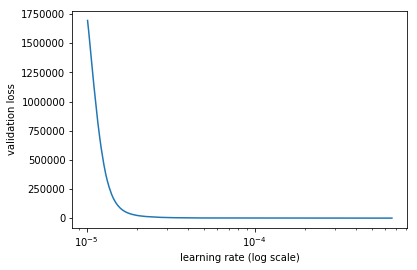

In [58]:
m.sched.plot()

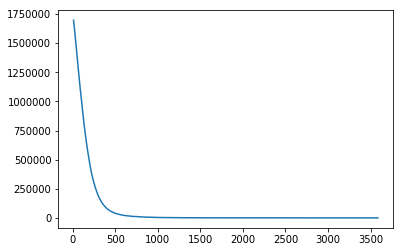

In [59]:
m.sched.plot_loss()

 11%|█▏        | 1351/11832 [00:07<00:55, 187.61it/s, loss=1.8e+03] 

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/srivbane/levon003/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/srivbane/levon003/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 31%|███       | 3611/11832 [00:19<00:43, 189.58it/s, loss=97.5]    


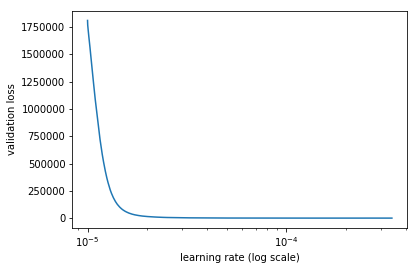

In [60]:
m.lr_find(start_lr=1e-5, end_lr=1)
m.sched.plot(n_skip=0, n_skip_end=0)

In [61]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(13, 7)
    (2): Embedding(85, 43)
    (3): Embedding(21808, 50)
    (4): Embedding(61, 31)
  )
  (lins): ModuleList(
    (0): Linear(in_features=134, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True)
)

In [62]:
lr = 1e-5
print("%.6f" % lr)

0.000010


In [63]:
m.fit(lr, 3, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                               
    0      71.405063  191.38889  6.100479  
    1      42.834011  172.800136 5.00347                         
    2      23.545643  167.104613 4.729942                        



[array([167.10461]), 4.729941896090493]

In [64]:
m.fit(lr, 2, metrics=[rmse], cycle_len=4)

epoch      trn_loss   val_loss   rmse                            
    0      26.567781  162.880409 4.720098  
    1      32.279904  161.129278 4.869701                        
    2      45.680895  159.840035 4.752886                        
    3      86.928587  159.884172 4.757599                        
    4      17.453537  161.773421 5.030971                        
    5      21.588721  162.351406 5.157657                        
    6      27.641948  162.187337 5.161141                        
    7      16.230912  162.236626 5.162743                        



[array([162.23663]), 5.162743226325738]

In [65]:
m.save('eightEpoch_1e5_model')

In [ ]:
m.load('eightEpoch_1e5_model')

In [66]:
pred_val_targs = m.predict_with_targs()

In [67]:
pred_val = m.predict()

In [68]:
pred_test = m.predict(is_test=True)

In [69]:
test['item_cnt_month'] = pred_test

In [70]:
output_filepath = os.path.join(derived_data_dir, "fastaiModel_preds.csv")
with open(output_filepath, 'w') as outfile:
    outfile.write("ID,item_cnt_month\n")
    for i, test_id in enumerate(test.ID):
        pred = pred_test[i]
        outfile.write("%d,%.2f\n" % (test_id, pred))
print("Finished.")

Finished.


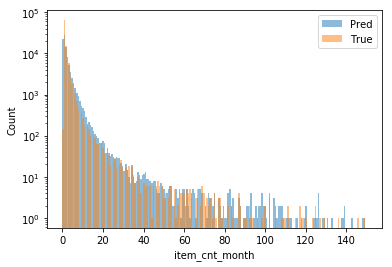

In [77]:
bins = np.linspace(-0.1, 150, num=200)
plt.hist(pred_val, bins=bins, alpha=0.5, log=True, label="Pred")
plt.hist(y_val, bins=bins, alpha=0.5, log=True, label="True")
plt.xlabel("item_cnt_month")
plt.ylabel("Count")
plt.legend()
plt.show()

In [78]:
pred_val[:,0].shape, y_val.shape

((94695,), (94695,))

In [79]:
np.sqrt(np.mean((pred_val[:,0] - y_val)**2))

12.73721441106761

## RandomForest on Basic Formulation

In [72]:
train.head()

,date_block_num,item_cnt_month,item_id,month,shop_id,year,item_category_id,tas
0,0,6.0,32,1,0,2013,40,-26.332001
1,0,3.0,33,1,0,2013,37,-26.332001
2,0,1.0,35,1,0,2013,40,-26.332001
3,0,1.0,43,1,0,2013,40,-26.332001
4,0,2.0,51,1,0,2013,57,-26.332001


In [73]:
feature_cols = ["year", "month", "shop_id", "item_id", "item_category_id"]

In [74]:
X = train.loc[:, feature_cols]
X_trn = train.loc[train.date_block_num <= 30, feature_cols]
X_val = train.loc[train.date_block_num > 30, feature_cols]  # leave months 31, 32, 33 as validation data
X_tst = test.loc[:, feature_cols]
X_trn.shape, X_val.shape, X_tst.shape

((1514429, 5), (94695, 5), (214200, 5))

In [75]:
y = train.item_cnt_month
y_trn = train[train.date_block_num <= 30].item_cnt_month
y_val = train[train.date_block_num > 30].item_cnt_month
y_trn.shape, y_val.shape

((1514429,), (94695,))

In [62]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

In [63]:
m.fit(X_trn, y_trn)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.99, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [124]:
y_val_pred = m.predict(X_val)
m.score(X_trn, y_trn), m.score(X_val, y_val), m.oob_score_

(0.8550891991600992, 0.14068042521389035, 0.6620306131618687)

In [125]:
print("Training RMSE")
y_trn_pred = m.predict(X_trn)
np.sqrt(sklearn.metrics.mean_squared_error(y_trn, y_trn_pred))

Training RMSE


3.1343597256366977

In [126]:
print("Validation RMSE")
np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_val_pred))

Validation RMSE


12.682391812875455

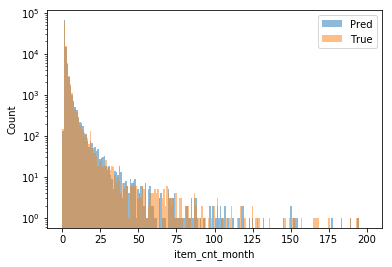

In [127]:
#bins = np.arange(-0.1, 10, 0.1)
bins = np.linspace(-0.1, 200, num=200)
plt.hist(y_val_pred, bins=bins, alpha=0.5, log=True, label="Pred")
plt.hist(y_val, bins=bins, alpha=0.5, log=True, label="True")
plt.xlabel("item_cnt_month")
plt.ylabel("Count")
plt.legend()
plt.show()

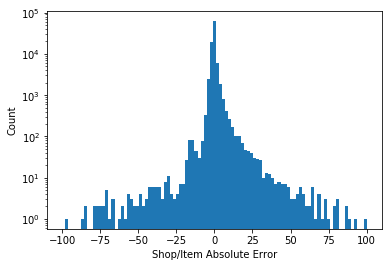

In [122]:
errors = y_val - y_val_pred
plt.hist(errors, bins=np.linspace(-100, 100, 100), log=True)
plt.xlabel("Shop/Item Absolute Error")
plt.ylabel("Count")
plt.show()

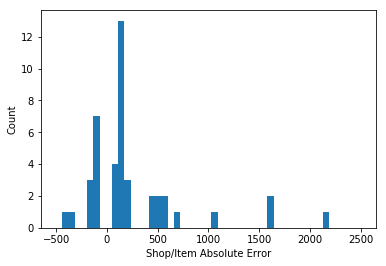

In [121]:
big_errors = errors[np.abs(errors) > 100]
plt.hist(big_errors, bins=np.linspace(-500, 2500, 50))
plt.xlabel("Shop/Item Absolute Error")
plt.ylabel("Count")
plt.show()
# This visualization of the major errors shows that in the worst cases we are systematically UNDERESTIMATING the true number sold... 
#But what percent of the RMSE is this?  It would seem like a small percent, or we wouldn't do that much worse than the baseline...

#### Make predictions on test data

In [142]:
y_tst_pred = m.predict(X_tst)

In [143]:
output_filepath = os.path.join(derived_data_dir, "randForest_preds.csv")
with open(output_filepath, 'w') as outfile:
    outfile.write("ID,item_cnt_month\n")
    for i, test_id in enumerate(test.ID):
        pred = y_tst_pred[i]
        outfile.write("%d,%.2f\n" % (test_id, pred))
print("Finished.")

Finished.


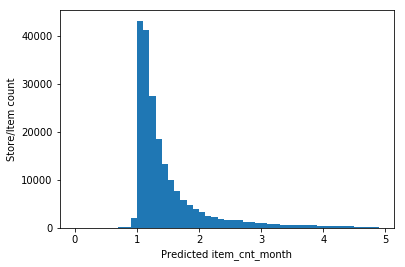

In [147]:
plt.hist(y_tst_pred, bins=np.arange(0, 5, 0.1) )
plt.xlabel("Predicted item_cnt_month")
plt.ylabel("Store/Item count")
plt.show()

#### Gradient Boosting Regressor

In [120]:
%%time
for depth in [1, 2, 3, 4, 5]:
    md = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=depth, random_state=0, loss='ls')
    md.fit(X_trn, y_trn)
    y_trn_pred = md.predict(X_trn)
    y_val_pred = md.predict(X_val)
    print(depth, np.sqrt(sklearn.metrics.mean_squared_error(y_trn, y_trn_pred)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_val_pred)))

1 8.102792276271881 13.604590571280909
2 7.094411750847324 13.249214353790201
3 6.789187535084146 13.129702132144626
4 6.184064988635418 12.8668806242627
5 5.66222516895761 12.65603598523646
CPU times: user 40min 27s, sys: 2min 30s, total: 42min 57s
Wall time: 4min 59s


In [132]:
# retrain on the full data
md = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0, loss='ls')
md.fit(X, y)
y_tst_pred = md.predict(X_tst)

In [133]:
output_filepath = os.path.join(derived_data_dir, "gradBoosting_preds.csv")
with open(output_filepath, 'w') as outfile:
    outfile.write("ID,item_cnt_month\n")
    for i, test_id in enumerate(test.ID):
        pred = y_tst_pred[i]
        outfile.write("%d,%.2f\n" % (test_id, pred))
print("Finished.")

Finished.
